In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hardfakevsrealfaces/data.csv
/kaggle/input/hardfakevsrealfaces/fake/fake_218.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_94.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_289.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_507.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_615.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_636.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_160.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_559.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_488.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_93.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_661.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_297.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_610.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_474.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_154.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_308.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_527.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_593.jpg
/kaggle/input/hardfakev

In [ ]:
import os
import random
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Concatenate

import kagglehub

# 1- Dataset loading

In [3]:
# Download latest version
path = kagglehub.dataset_download("hamzaboulahia/hardfakevsrealfaces")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/hardfakevsrealfaces


In [4]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

fake_dir = os.path.join(path, "fake")
real_dir = os.path.join(path, "real")

image_ext = (".jpg", ".jpeg", ".png")

fake_images = [f for f in os.listdir(fake_dir) if f.endswith(image_ext)]
real_images = [f for f in os.listdir(real_dir) if f.endswith(image_ext)]

print("Fake images:", len(fake_images))
print("Real images:", len(real_images))
print("Total images:", len(fake_images) + len(real_images))

Fake images: 700
Real images: 589
Total images: 1289


# 2- Train / validation / test split

In [5]:
test_size = 0.2

fake_train, fake_test = train_test_split(fake_images, test_size=test_size, random_state=42)
real_train, real_test = train_test_split(real_images, test_size=test_size, random_state=42)

work_dir = "/kaggle/working/dataset_split"
for split in ["train", "test"]:
    for cls in ["fake", "real"]:
        os.makedirs(os.path.join(work_dir, split, cls), exist_ok=True)
def copy_images(files, src_dir, dst_dir):
    for f in files:
        shutil.copy2(os.path.join(src_dir, f), os.path.join(dst_dir, f))

copy_images(fake_train, fake_dir, os.path.join(work_dir, "train", "fake"))
copy_images(real_train, real_dir, os.path.join(work_dir, "train", "real"))

# Copy test images
copy_images(fake_test, fake_dir, os.path.join(work_dir, "test", "fake"))
copy_images(real_test, real_dir, os.path.join(work_dir, "test", "real"))

train_dir = os.path.join(work_dir, "train")
test_dir  = os.path.join(work_dir, "test")

print("\nDataset split")
print(f"Train: {len(fake_train)} fake + {len(real_train)} real")
print(f"Test:  {len(fake_test)} fake + {len(real_test)} real")

# 3- Data exploration and visualization

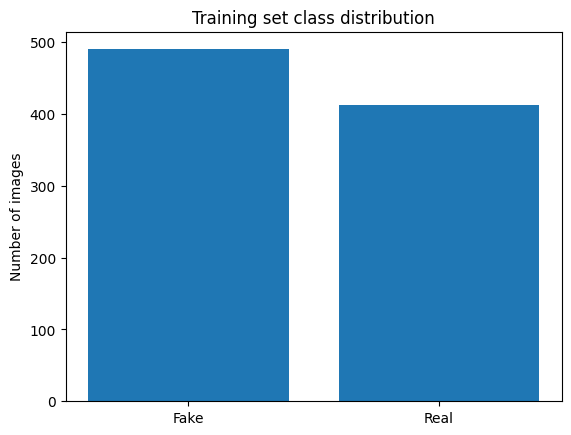

In [8]:
classes = ['Fake', 'Real']
train_counts = [len(fake_train), len(real_train)]

plt.bar(classes, train_counts)
plt.ylabel('Number of images')
plt.title('Training set class distribution')
plt.show()

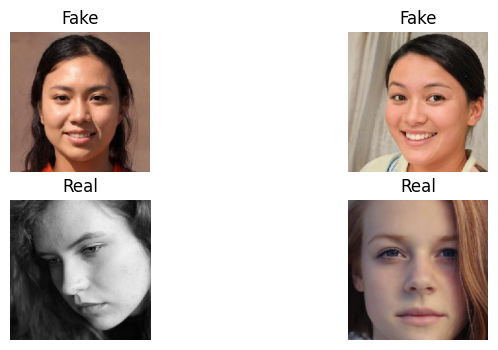

In [9]:
plt.figure(figsize=(8, 4))

# show 2 fake images
for i in range(2):
    img_path = os.path.join(train_dir, 'fake', random.choice(fake_train))
    img = image.load_img(img_path, target_size=(224, 224))
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title('Fake')
    plt.axis('off')

# show 2 real images
for i in range(2):
    img_path = os.path.join(train_dir, 'real', random.choice(real_train))
    img = image.load_img(img_path, target_size=(224, 224))
    plt.subplot(2, 2, i + 3)
    plt.imshow(img)
    plt.title('Real')
    plt.axis('off')

plt.show()

# 4- Data Augmentation

## Data Augmentation Decision:
---------------------------
Use moderate augmentation on the training set only.
Validation and test must stay unchanged for fair evaluation
Faces can appear with small rotations or shifts
We want more variation without destroying fake/real artifacts

Augmentation Applied:
1. Rotation: ±15 degrees (faces can be slightly tilted)
2. Width/Height Shift: 10% (slight position variations)
3. Horizontal Flip: Yes (faces can be mirrored)
4. Zoom: 10% (different face sizes)
5. Fill Mode: Nearest (to avoid artifacts)

In [11]:
IMG_SIZE = 224
BATCH_SIZE = 32
N_SPLITS = 5

# Full paths and labels
all_train_files  = [os.path.join(train_dir, 'fake', f) for f in fake_train] + \
                   [os.path.join(train_dir, 'real', f) for f in real_train]
all_train_labels = [0]*len(fake_train) + [1]*len(real_train)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

Found 902 images belonging to 2 classes.
Found 193 images belonging to 2 classes.
Found 194 images belonging to 2 classes.


# 5- Transfer Learning Model RESNET50

Model Architecture:
ResNet50 Transfer Learning Architecture:
--------------------------------------------------------------------------------
1. Base Model: ResNet50 (pre-trained on ImageNet)
   - Input: 224x224x3 RGB images
   - Architecture: 50 convolutional layers with skip connections
   - Feature extraction: From low-level (edges) to high-level (faces)
   - Status: Initially frozen (weights not updated)

2. Custom Classification Head:
   - GlobalAveragePooling2D: Reduces spatial dimensions
   - Dense(256, ReLU): High-level feature learning
   - Dropout(0.5): Regularization to prevent overfitting
   - Dense(128, ReLU): Further feature refinement
   - Dropout(0.3): Additional regularization
   - Dense(1, Sigmoid): Binary classification output (fake=0, real=1)

In [15]:
def create_model(img_size=IMG_SIZE):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.7),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


Parameter Summary:
Total parameters: 23,850,113
Trainable parameters: 262,401
Non-trainable parameters: 23,587,712


# 6- K-Fold Training

## Training Parameters:
-------------------
Loss Function: Binary Crossentropy
  - Suitable for binary classification (fake vs real)
  - Measures difference between predicted and actual probabilities

Optimizer: Adam with learning rate 0.001.

Metrics: Accuracy

Callbacks: EarlyStopping: Stop if val_loss doesn't improve for 7 epochs, restores best weights)

Batch Size: 32
Epochs: 20 (maximum, may stop early)

because of EarlyStopping:

`` early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
) ``
monitor="val_loss" = watches validation loss.

patience=7 =training stops if validation loss does not improve for 7 consecutive epochs.

restore_best_weights=True = keeps the weights from the epoch with the best validation loss.

In [17]:
kfold_df = pd.DataFrame({'filename': all_train_files, 'class': all_train_labels})
kfold_df['class'] = kfold_df['class'].map({0: 'fake', 1: 'real'})

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
fold_val_accuracies, fold_models, fold_histories = [], [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(kfold_df['filename'], kfold_df['class'])):
    print(f"\nFold {fold+1}/{N_SPLITS} ---")

    # Slice the DataFrame directly
    train_gen = train_datagen.flow_from_dataframe(
        kfold_df.iloc[train_idx], x_col='filename', y_col='class',
        target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='binary'
    )
    val_gen = valid_datagen.flow_from_dataframe(
        kfold_df.iloc[val_idx], x_col='filename', y_col='class',
        target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
    )

    # Model & Training
    model = create_model()
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = model.fit(train_gen, validation_data=val_gen, epochs=20, callbacks=[early_stop], verbose=1)

    # Storage
    fold_val_accuracies.append(max(history.history['val_accuracy']))
    fold_histories.append(history.history)
    fold_models.append(model)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Model summary
model.summary()

# Count parameters
total_params = model.count_params()
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
non_trainable_params = total_params - trainable_params

print(f"\nParameter Summary:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {non_trainable_params:,}")

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 343ms/step - accuracy: 0.5479 - loss: 0.6874 - val_accuracy: 0.5440 - val_loss: 0.6674
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 327ms/step - accuracy: 0.5549 - loss: 0.6877 - val_accuracy: 0.6218 - val_loss: 0.6708
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 329ms/step - accuracy: 0.5185 - loss: 0.6911 - val_accuracy: 0.5440 - val_loss: 0.6717
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 334ms/step - accuracy: 0.5750 - loss: 0.6793 - val_accuracy: 0.5440 - val_loss: 0.6615
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 327ms/step - accuracy: 0.5207 - loss: 0.6950 - val_accuracy: 0.5440 - val_loss: 0.6657
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 329ms/step - accuracy: 0.5498 - loss: 0.6782 - val_accuracy: 0.5440 - val_loss: 0.6634
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 325ms/step - accuracy: 0.5898 - loss: 0.6752 - val_accuracy: 0.5440 - val_loss: 0.6619
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 333ms/step - accuracy: 0.5547 - loss: 0.6846 - val_accur

# 7- Training Curves (Best fold - Before Fine-tuning)

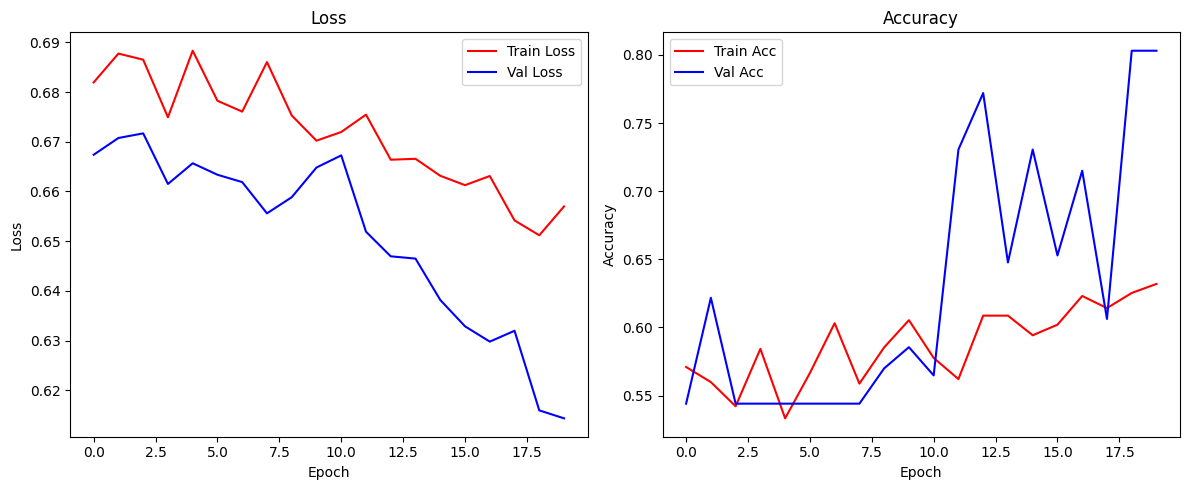

In [19]:
best_fold_idx = np.argmax(fold_val_accuracies)
best_fold_history = fold_histories[best_fold_idx]

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(best_fold_history['loss'], 'r', label='Train Loss')
plt.plot(best_fold_history['val_loss'], 'b', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Best Fold Loss (Before Fine-tuning)')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(best_fold_history['accuracy'], 'r', label='Train Acc')
plt.plot(best_fold_history['val_accuracy'], 'b', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Best Fold Accuracy (Before Fine-tuning)')
plt.legend()

plt.tight_layout()
plt.show()

# 8- Fine-Tuning (Best Fold)

In [20]:
# Select the best model from the K-Fold results
best_model = fold_models[np.argmax(fold_val_accuracies)]

# Split the df created in Step 6 into train and validation
train_df, val_df = train_test_split(
    kfold_df, test_size=0.1, random_state=42, stratify=kfold_df['class']
)

# Quick Generator setup using the split DataFrames
full_train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='filename', y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='binary'
)
full_val_gen = valid_datagen.flow_from_dataframe(
    val_df, x_col='filename', y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
)

# Unfreeze the last 15 layers of the base ResNet50 model
base_model = best_model.layers[0]
base_model.trainable = True
for layer in base_model.layers[:-15]:
    layer.trainable = False

# Re-compile and Fine-tune
best_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5), 
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_finetune_full = best_model.fit(
    full_train_gen, validation_data=full_val_gen,
    epochs=20, callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Unfreezing top 15 layers of ResNet50
Epoch 20/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 36s 723ms/step - accuracy: 0.6758 - loss: 0.5779 - val_accuracy: 0.4974 - val_loss: 0.6835
Epoch 21/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 339ms/step - accuracy: 0.8583 - loss: 0.3525 - val_accuracy: 0.5026 - val_loss: 0.6668
Epoch 22/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 358ms/step - accuracy: 0.8732 - loss: 0.3460 - val_accuracy: 0.8549 - val_loss: 0.4976
Epoch 23/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 334ms/step - accuracy: 0.8831 - loss: 0.2736 - val_accuracy: 0.5440 - val_loss: 0.6391
Epoch 24/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 343ms/step - accuracy: 0.9149 - loss: 0.2158 - val_accuracy: 0.5440 - val_loss: 0.7019
Epoch 25/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 342ms/step - accuracy: 0.8954 - loss: 0.2465 - val_accuracy: 0.5648 - val_loss: 0.7181
Epoch 26/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 333ms/step - accuracy: 0.9280 - loss: 0.1989 - val_accuracy: 0.5907 - val_loss: 0.7632
Epoch 27/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 352ms/step

# 9- Training Curves after Fine-Tuning

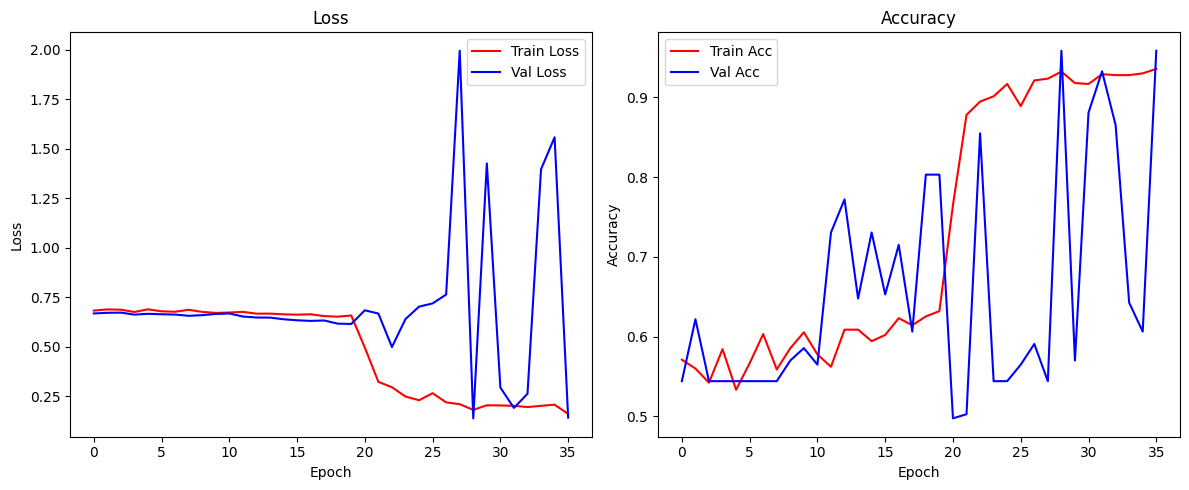


Final Training Accuracy: 0.9357
Final Validation Accuracy: 0.9585
Train-Val Gap: -0.0229
Minimal overfitting


In [21]:
history_combined_full = {
    'loss': best_fold_history['loss'] + history_finetune_full.history['loss'],
    'val_loss': best_fold_history['val_loss'] + history_finetune_full.history['val_loss'],
    'accuracy': best_fold_history['accuracy'] + history_finetune_full.history['accuracy'],
    'val_accuracy': best_fold_history['val_accuracy'] + history_finetune_full.history['val_accuracy'],
}

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history_combined_full['loss'], 'r', label='Train Loss')
plt.plot(history_combined_full['val_loss'], 'b', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss (Best Fold + Full Fine-tuning)')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history_combined_full['accuracy'], 'r', label='Train Acc')
plt.plot(history_combined_full['val_accuracy'], 'b', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy (Best Fold + Full Fine-tuning)')
plt.legend()

plt.tight_layout()
plt.show()

# Overfitting check
final_train_acc = history_combined_full['accuracy'][-1]
final_val_acc = history_combined_full['val_accuracy'][-1]
gap = final_train_acc - final_val_acc

print(f"\nFinal Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Train-Val Gap: {gap:.4f}")

if gap < 0.05:
    print("Minimal overfitting")
elif gap < 0.10:
    print("Slight overfitting")
else:
    print("Significant overfitting")

# 10- Test Set Evaluation

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step

Test Accuracy : 0.9639
Test Precision: 0.9881
Test Recall   : 0.9326
Test F1-score : 0.9595

Classification Report:
              precision    recall  f1-score   support

        Fake       0.95      0.99      0.97       105
        Real       0.99      0.93      0.96        89

    accuracy                           0.96       194
   macro avg       0.97      0.96      0.96       194
weighted avg       0.97      0.96      0.96       194



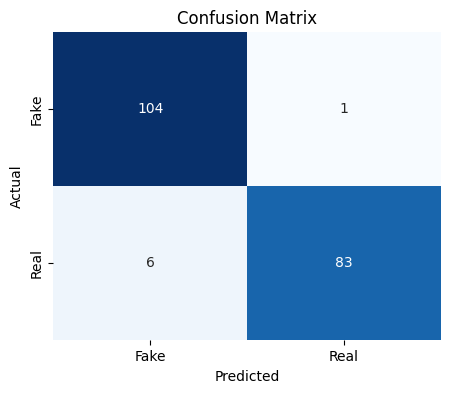

In [26]:
test_gen.reset()
y_pred_probs = best_model.predict(test_gen)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = test_gen.classes

# Metrics
test_acc = accuracy_score(y_true, y_pred)
test_prec = precision_score(y_true, y_pred)
test_rec = recall_score(y_true, y_pred)
test_f1 = f1_score(y_true, y_pred)

print(f"\nTest Accuracy : {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall   : {test_rec:.4f}")
print(f"Test F1-score : {test_f1:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Fake','Real']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Fake','Real'], yticklabels=['Fake','Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 11- Hyperparameter experiments

In [27]:
def train_model(batch_size=32, lr=0.001, epochs=10, use_early_stop=False):
    # Create a simple train/val split from all_train_files
    train_files_temp, val_files_temp, train_labels_temp, val_labels_temp = train_test_split(
        all_train_files, all_train_labels, test_size=0.2, random_state=42, stratify=all_train_labels
    )
    
    # Convert to DataFrames
    train_df_temp = pd.DataFrame({'filename': train_files_temp, 'class': train_labels_temp})
    val_df_temp = pd.DataFrame({'filename': val_files_temp, 'class': val_labels_temp})
    label_map = {0: 'fake', 1: 'real'}
    train_df_temp['class'] = train_df_temp['class'].map(label_map)
    val_df_temp['class'] = val_df_temp['class'].map(label_map)
    
    # Generators
    train_gen_temp = train_datagen.flow_from_dataframe(
        train_df_temp, x_col='filename', y_col='class',
        target_size=(IMG_SIZE, IMG_SIZE), batch_size=batch_size, class_mode='binary'
    )
    val_gen_temp = valid_datagen.flow_from_dataframe(
        val_df_temp, x_col='filename', y_col='class',
        target_size=(IMG_SIZE, IMG_SIZE), batch_size=batch_size, class_mode='binary', shuffle=False
    )
    
    # Create model
    model_temp = create_model()
    
    # Update learning rate
    model_temp.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Callbacks
    callbacks_list = []
    if use_early_stop:
        callbacks_list.append(EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True))
    
    # Train
    history_temp = model_temp.fit(
        train_gen_temp,
        validation_data=val_gen_temp,
        epochs=epochs,
        callbacks=callbacks_list,
        verbose=0  # Silent training
    )
    
    # Return best validation accuracy
    best_val_acc = max(history_temp.history['val_accuracy'])
    return best_val_acc

Experiments: 3 batch sizes, 3 learning rates, 3 epoch values, with/without early stopping

In [ ]:
# EXPERIMENT 1: Effect of BATCH SIZE (fix other params)
print("\n1. Testing Batch Size Effect:")
batch_results = []
for bs in [16, 32, 64]:
    val_acc = train_model(batch_size=bs, lr=0.001, epochs=10, use_early_stop=True)
    batch_results.append({'Batch Size': bs, 'Val Accuracy': val_acc})
    print(f"  Batch Size {bs}: Val Acc = {val_acc:.4f}")


In [ ]:
# EXPERIMENT 2: Effect of LEARNING RATE
print("\n2. Testing Learning Rate Effect:")
lr_results = []
for lr in [0.001, 0.0005, 0.0001]:
    val_acc = train_model(batch_size=32, lr=lr, epochs=10, use_early_stop=True)
    lr_results.append({'Learning Rate': lr, 'Val Accuracy': val_acc})
    print(f"  Learning Rate {lr}: Val Acc = {val_acc:.4f}")

In [ ]:
# EXPERIMENT 3: Effect of EPOCHS
print("\n3. Testing Epochs Effect:")
epoch_results = []
for ep in [5, 10, 20]:
    val_acc = train_model(batch_size=32, lr=0.001, epochs=ep, use_early_stop=False)
    epoch_results.append({'Epochs': ep, 'Val Accuracy': val_acc})
    print(f"  Epochs {ep}: Val Acc = {val_acc:.4f}")

In [ ]:
# EXPERIMENT 4: Effect of EARLY STOPPING
print("\n4. Testing Early Stopping Effect:")
es_results = []
for es in [True, False]:
    val_acc = train_model(batch_size=32, lr=0.001, epochs=20, use_early_stop=es)
    es_results.append({'Early Stopping': es, 'Val Accuracy': val_acc})
    print(f"  Early Stopping {es}: Val Acc = {val_acc:.4f}")

In [ ]:
df_batch = pd.DataFrame(batch_results)
df_lr    = pd.DataFrame(lr_results)
df_epoch = pd.DataFrame(epoch_results)
df_es    = pd.DataFrame(es_results)

# Plot all 4 hyperparameter effects in one figure
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot function to reduce repetition
def plot_bar(ax, df, x_col, y_col, color, title):
    ax.bar(df[x_col].astype(str), df[y_col], color=color)
    ax.set_title(title)
    ax.set_ylabel('Validation Accuracy')
    ax.set_ylim([0.5, 1.0])

plot_bar(axes[0,0], df_batch, 'Batch Size', 'Val Accuracy', 'skyblue', 'Batch Size Effect')
plot_bar(axes[0,1], df_lr,    'Learning Rate', 'Val Accuracy', 'salmon', 'Learning Rate Effect')
plot_bar(axes[1,0], df_epoch, 'Epochs', 'Val Accuracy', 'lightgreen', 'Epochs Effect')
plot_bar(axes[1,1], df_es,    'Early Stopping', 'Val Accuracy', 'gold', 'Early Stopping Effect')

plt.tight_layout()
plt.savefig('hyperparameter_effects.png', dpi=300, bbox_inches='tight')
plt.show() 


# 12- Bonus Section

## Integrating Extra Layers into ResNet50

In [ ]:
base_model_b1 = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model_b1.trainable = False

model_bonus1 = models.Sequential([
    base_model_b1,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model_bonus1.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\nModel Architecture:")
model_bonus1.summary()

# Use the best fold's data for training
train_gen.reset()
val_gen.reset()

history_bonus1 = model_bonus1.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

# Evaluate on test set
test_gen.reset()
y_pred_bonus1 = model_bonus1.predict(test_gen)
y_pred_bonus1 = (y_pred_bonus1 > 0.5).astype(int).flatten()

acc_bonus1 = accuracy_score(test_gen.classes, y_pred_bonus1)
prec_bonus1 = precision_score(test_gen.classes, y_pred_bonus1)
rec_bonus1 = recall_score(test_gen.classes, y_pred_bonus1)
f1_bonus1 = f1_score(test_gen.classes, y_pred_bonus1)

print(f"\nBonus Model 1 Test Results:")
print(f"  Accuracy:  {acc_bonus1:.4f}")
print(f"  Precision: {prec_bonus1:.4f}")
print(f"  Recall:    {rec_bonus1:.4f}")
print(f"  F1-Score:  {f1_bonus1:.4f}")

## Combining Two CNN Architectures 

combine ResNet50 + MobileNetV2 by concatenating their features before classification.

In [ ]:
# Load base models
resnet_b2 = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
mobilenet_b2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
resnet_b2.trainable = False
mobilenet_b2.trainable = False

# Build fusion architecture
x1 = layers.GlobalAveragePooling2D()(resnet_b2.output)
x2 = layers.GlobalAveragePooling2D()(mobilenet_b2.output)
combined = layers.Concatenate()([x1, x2])
combined = layers.Dense(256, activation='relu')(combined)
combined = layers.Dropout(0.5)(combined)
output = layers.Dense(1, activation='sigmoid')(combined)

model_bonus2 = Model(inputs=[resnet_b2.input, mobilenet_b2.input], outputs=output)

model_bonus2.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\nModel Architecture:")
model_bonus2.summary()

# Dual generator for two inputs
def dual_generator(generator):
    for batch_x, batch_y in generator:
        yield [batch_x, batch_x], batch_y

# Train
train_gen.reset()
val_gen.reset()

history_bonus2 = model_bonus2.fit(
    dual_generator(train_gen),
    steps_per_epoch=len(train_gen),
    validation_data=dual_generator(val_gen),
    validation_steps=len(val_gen),
    epochs=20,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

# Evaluate on test set
test_gen.reset()
y_pred_bonus2 = model_bonus2.predict(
    dual_generator(test_gen),
    steps=len(test_gen)
)
y_pred_bonus2 = (y_pred_bonus2 > 0.5).astype(int).flatten()

acc_bonus2 = accuracy_score(test_gen.classes, y_pred_bonus2)
prec_bonus2 = precision_score(test_gen.classes, y_pred_bonus2)
rec_bonus2 = recall_score(test_gen.classes, y_pred_bonus2)
f1_bonus2 = f1_score(test_gen.classes, y_pred_bonus2)

print(f"\nBonus Model 2 Test Results:")
print(f"  Accuracy:  {acc_bonus2:.4f}")
print(f"  Precision: {prec_bonus2:.4f}")
print(f"  Recall:    {rec_bonus2:.4f}")
print(f"  F1-Score:  {f1_bonus2:.4f}")

# COMPARISON TABLE
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': ['Base ResNet50', 'Enhanced ResNet50', 'ResNet+MobileNet Fusion'],
    'Accuracy': [test_acc, acc_bonus1, acc_bonus2],
    'Precision': [test_prec, prec_bonus1, prec_bonus2],
    'Recall': [test_rec, rec_bonus1, rec_bonus2],
    'F1-Score': [test_f1, f1_bonus1, f1_bonus2]
})

print("\n" + comparison_df.to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comparison_df))
width = 0.2

ax.bar(x - 1.5*width, comparison_df['Accuracy'], width, label='Accuracy', color='#3498db')
ax.bar(x - 0.5*width, comparison_df['Precision'], width, label='Precision', color='#2ecc71')
ax.bar(x + 0.5*width, comparison_df['Recall'], width, label='Recall', color='#e74c3c')
ax.bar(x + 1.5*width, comparison_df['F1-Score'], width, label='F1-Score', color='#f39c12')

ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('Scores', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
ax.legend()
ax.set_ylim([0.85, 1.0])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()